FDA思路
y = BX
其中y是目标值，X是输入向量，B是拟合参数
考虑时间序列问题，则X = X[t-n:t-1], B = B[t-n:t-1]，y = X[t]
考虑时序上的一组基P[t]，则有B[t] = CP[t]，C是P[t]的拟合参数


方法
基于基中心与scale构造一组基，对于时间序列输入t，返回对应的P[t]，则y = X[t] = B[t-n:t-1]X[t-n:t-1] = CP[t-n:t-1]X[t-n:t-1]
即对P[t-n:t-1]X[t-n:t-1] 与 y = X[t]做线性拟合可得C

基类
支持bspline 和 gauss spline

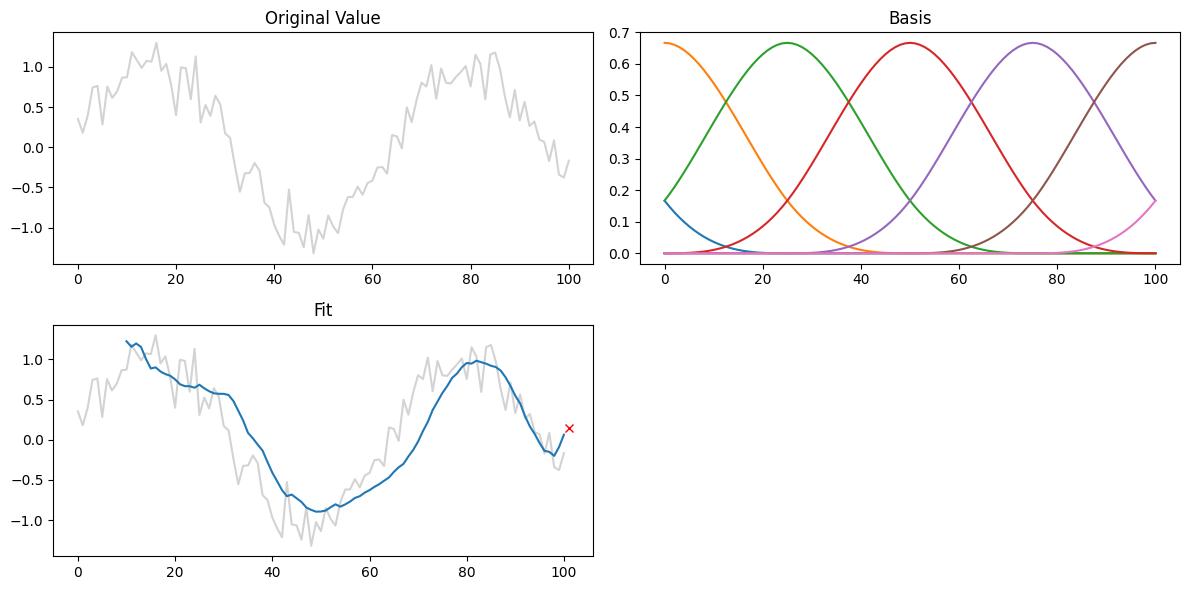

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.signal import gauss_spline
from functools import partial
from sklearn.linear_model import LinearRegression

# 数据时间起点，终点，长度
time_start = 0
time_end = 100
time_length = 101

# 基数量
num_basis = 7 
scale = (time_end- time_start)/(num_basis-3)
center = np.linspace(time_start-scale, time_end+scale, num_basis)

# 基类型
type = 'bspline'

# 基阶数
order = 3

# 时间序列历史窗口
window = 10


# 0. 基类
class Basis():
    def __init__(self, type, center, scale, **params):
        self.center = np.array(center)
        self.scale = scale
        if type == 'bspline':
            extrapolate = True
            if 'extrapolate' in params:
                extrapolate = params['extrapolate']
            assert 'order' in params,'please define the order of bspine with order=n'
            k = params['order']
            self.basis = BSpline.basis_element(np.linspace(-2, 2, k+2), extrapolate)
        elif type == 'gauss_spline':
            assert 'order' in params,'please define the order of gauss spine with order=n'
            k = params['order']
            self.basis = partial(gauss_spline, n = k)

    def t(self, t):
        if isinstance(t, int) or isinstance(t, float):
            t = [t] 
        t = (np.array(t).reshape(len(t),-1) - self.center) / self.scale
        return np.nan_to_num(self.basis(t).transpose())
        
        
# 1. 生产样本数据sin(t)+噪音
np.random.seed(0)
time_points = np.linspace(time_start, time_end, time_length)
value = np.sin(time_points/10) + np.random.normal(0, 0.2, len(time_points))

# 2. 定义基
basis = Basis(type=type, center = center, scale = scale, order = order, extrapolate = False)

# 3. 变换原值，线性回归
y = value[window:]
X = np.zeros((len(y), len(basis.center)))
for i in range(len(y)):
    X[i] = np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window])
reg = LinearRegression().fit(X, y)
y_head = reg.predict(X)
# print(reg.coef_)

i = len(y)
y_ahead=reg.predict(np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window]).reshape(1,-1))


# 4. 画图
# 原值
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(time_points, value, color='lightgrey')
plt.title("Original Value")

# 基
plt.subplot(2, 2, 2)
basis_set = basis.t(time_points)
for basis_ele in basis_set:
    plt.plot(time_points, basis_ele)
plt.title("Basis")

# Principal components
plt.subplot(2, 2, 3)
plt.plot(time_points, value, color='lightgrey')
plt.plot(time_points[window:], y_head)
plt.plot(time_points[-1]+1, y_ahead, 'rx')
plt.title("Fit")


plt.tight_layout()
plt.show()

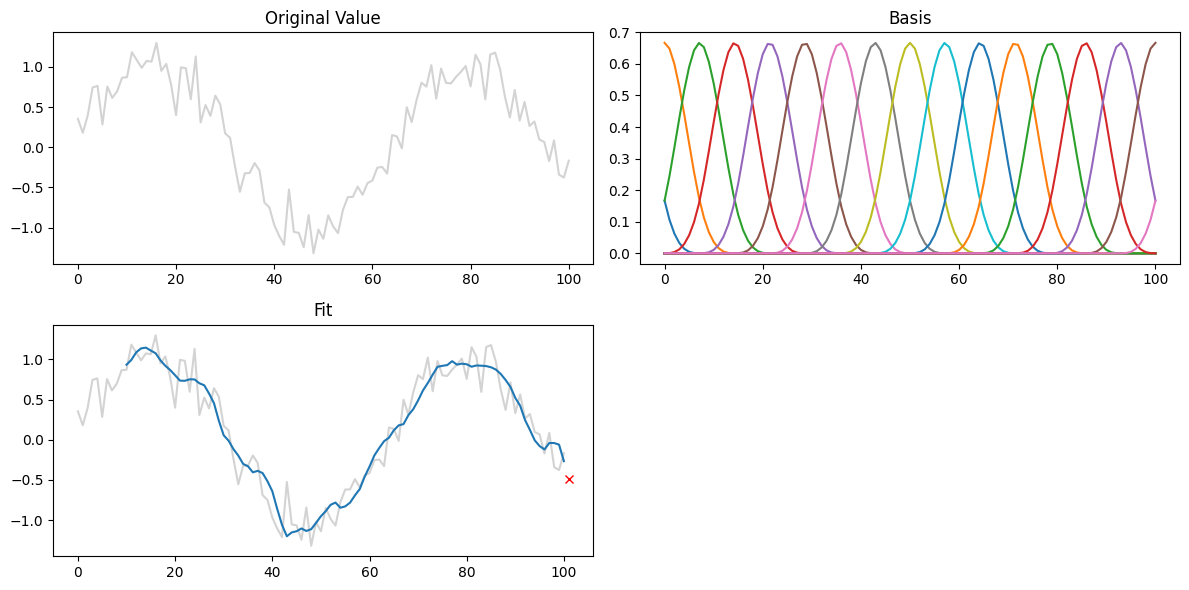

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.signal import gauss_spline
from functools import partial
from sklearn.linear_model import LinearRegression

# 数据时间起点，终点，长度
time_start = 0
time_end = 100
time_length = 101

# 基数量
num_basis = 17 
scale = (time_end- time_start)/(num_basis-3)
center = np.linspace(time_start-scale, time_end+scale, num_basis)

# 基类型
type = 'bspline'

# 基阶数
order = 3

# 时间序列历史窗口
window = 10


# 0. 基类
class Basis():
    def __init__(self, type, center, scale, **params):
        self.center = np.array(center)
        self.scale = scale
        if type == 'bspline':
            extrapolate = True
            if 'extrapolate' in params:
                extrapolate = params['extrapolate']
            assert 'order' in params,'please define the order of bspine with order=n'
            k = params['order']
            self.basis = BSpline.basis_element(np.linspace(-2, 2, k+2), extrapolate)
        elif type == 'gauss_spline':
            assert 'order' in params,'please define the order of gauss spine with order=n'
            k = params['order']
            self.basis = partial(gauss_spline, n = k)

    def t(self, t):
        if isinstance(t, int) or isinstance(t, float):
            t = [t] 
        t = (np.array(t).reshape(len(t),-1) - self.center) / self.scale
        return np.nan_to_num(self.basis(t).transpose())
        
        
# 1. 生产样本数据sin(t)+噪音
np.random.seed(0)
time_points = np.linspace(time_start, time_end, time_length)
value = np.sin(time_points/10) + np.random.normal(0, 0.2, len(time_points))

# 2. 定义基
basis = Basis(type=type, center = center, scale = scale, order = order, extrapolate = False)

# 3. 变换原值，线性回归
y = value[window:]
X = np.zeros((len(y), len(basis.center)))
for i in range(len(y)):
    X[i] = np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window])
reg = LinearRegression().fit(X, y)
y_head = reg.predict(X)
# print(reg.coef_)

i = len(y)
y_ahead=reg.predict(np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window]).reshape(1,-1))


# 4. 画图
# 原值
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(time_points, value, color='lightgrey')
plt.title("Original Value")

# 基
plt.subplot(2, 2, 2)
basis_set = basis.t(time_points)
for basis_ele in basis_set:
    plt.plot(time_points, basis_ele)
plt.title("Basis")

# Principal components
plt.subplot(2, 2, 3)
plt.plot(time_points, value, color='lightgrey')
plt.plot(time_points[window:], y_head)
plt.plot(time_points[-1]+1, y_ahead, 'rx')
plt.title("Fit")


plt.tight_layout()
plt.show()

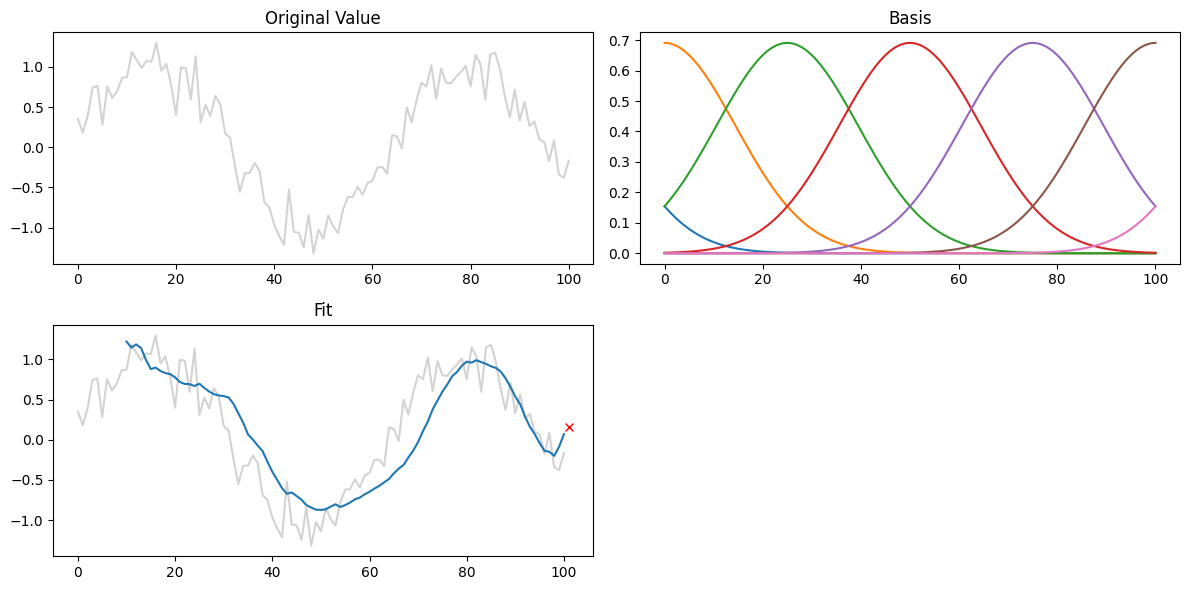

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.signal import gauss_spline
from functools import partial
from sklearn.linear_model import LinearRegression

# 数据时间起点，终点，长度
time_start = 0
time_end = 100
time_length = 101

# 基数量
num_basis = 7 
scale = (time_end- time_start)/(num_basis-3)
center = np.linspace(time_start-scale, time_end+scale, num_basis)

# 基类型
type = 'gauss_spline'

# 基阶数
order = 3

# 时间序列历史窗口
window = 10


# 0. 基类
class Basis():
    def __init__(self, type, center, scale, **params):
        self.center = np.array(center)
        self.scale = scale
        if type == 'bspline':
            extrapolate = True
            if 'extrapolate' in params:
                extrapolate = params['extrapolate']
            assert 'order' in params,'please define the order of bspine with order=n'
            k = params['order']
            self.basis = BSpline.basis_element(np.linspace(-2, 2, k+2), extrapolate)
        elif type == 'gauss_spline':
            assert 'order' in params,'please define the order of gauss spine with order=n'
            k = params['order']
            self.basis = partial(gauss_spline, n = k)

    def t(self, t):
        if isinstance(t, int) or isinstance(t, float):
            t = [t] 
        t = (np.array(t).reshape(len(t),-1) - self.center) / self.scale
        return np.nan_to_num(self.basis(t).transpose())
        
        
# 1. 生产样本数据sin(t)+噪音
np.random.seed(0)
time_points = np.linspace(time_start, time_end, time_length)
value = np.sin(time_points/10) + np.random.normal(0, 0.2, len(time_points))

# 2. 定义基
basis = Basis(type=type, center = center, scale = scale, order = order, extrapolate = False)

# 3. 变换原值，线性回归
y = value[window:]
X = np.zeros((len(y), len(basis.center)))
for i in range(len(y)):
    X[i] = np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window])
reg = LinearRegression().fit(X, y)
y_head = reg.predict(X)
# print(reg.coef_)

i = len(y)
y_ahead=reg.predict(np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window]).reshape(1,-1))


# 4. 画图
# 原值
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(time_points, value, color='lightgrey')
plt.title("Original Value")

# 基
plt.subplot(2, 2, 2)
basis_set = basis.t(time_points)
for basis_ele in basis_set:
    plt.plot(time_points, basis_ele)
plt.title("Basis")

# Principal components
plt.subplot(2, 2, 3)
plt.plot(time_points, value, color='lightgrey')
plt.plot(time_points[window:], y_head)
plt.plot(time_points[-1]+1, y_ahead, 'rx')
plt.title("Fit")


plt.tight_layout()
plt.show()

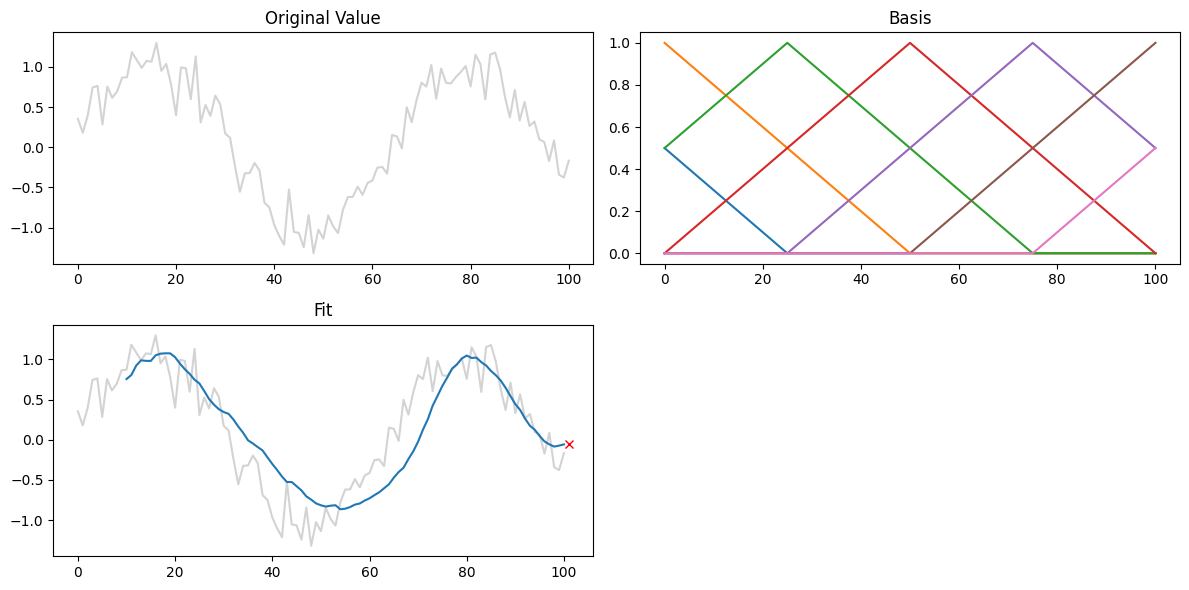

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.signal import gauss_spline
from functools import partial
from sklearn.linear_model import LinearRegression

# 数据时间起点，终点，长度
time_start = 0
time_end = 100
time_length = 101

# 基数量
num_basis = 7 
scale = (time_end- time_start)/(num_basis-3)
center = np.linspace(time_start-scale, time_end+scale, num_basis)

# 基类型
type = 'bspline'

# 基阶数
order = 1

# 时间序列历史窗口
window = 10


# 0. 基类
class Basis():
    def __init__(self, type, center, scale, **params):
        self.center = np.array(center)
        self.scale = scale
        if type == 'bspline':
            extrapolate = True
            if 'extrapolate' in params:
                extrapolate = params['extrapolate']
            assert 'order' in params,'please define the order of bspine with order=n'
            k = params['order']
            self.basis = BSpline.basis_element(np.linspace(-2, 2, k+2), extrapolate)
        elif type == 'gauss_spline':
            assert 'order' in params,'please define the order of gauss spine with order=n'
            k = params['order']
            self.basis = partial(gauss_spline, n = k)

    def t(self, t):
        if isinstance(t, int) or isinstance(t, float):
            t = [t] 
        t = (np.array(t).reshape(len(t),-1) - self.center) / self.scale
        return np.nan_to_num(self.basis(t).transpose())
        
        
# 1. 生产样本数据sin(t)+噪音
np.random.seed(0)
time_points = np.linspace(time_start, time_end, time_length)
value = np.sin(time_points/10) + np.random.normal(0, 0.2, len(time_points))

# 2. 定义基
basis = Basis(type=type, center = center, scale = scale, order = order, extrapolate = False)

# 3. 变换原值，线性回归
y = value[window:]
X = np.zeros((len(y), len(basis.center)))
for i in range(len(y)):
    X[i] = np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window])
reg = LinearRegression().fit(X, y)
y_head = reg.predict(X)
# print(reg.coef_)

i = len(y)
y_ahead=reg.predict(np.dot(basis.t(np.linspace(i, i + window - 1, window)), value[i:i + window]).reshape(1,-1))


# 4. 画图
# 原值
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(time_points, value, color='lightgrey')
plt.title("Original Value")

# 基
plt.subplot(2, 2, 2)
basis_set = basis.t(time_points)
for basis_ele in basis_set:
    plt.plot(time_points, basis_ele)
plt.title("Basis")

# Principal components
plt.subplot(2, 2, 3)
plt.plot(time_points, value, color='lightgrey')
plt.plot(time_points[window:], y_head)
plt.plot(time_points[-1]+1, y_ahead, 'rx')
plt.title("Fit")


plt.tight_layout()
plt.show()